In [4]:
# Importaciones y preparaciones previas
!pip install umap-learn

import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
from sklearn.manifold import TSNE
from torch import Tensor
from typing import Type
import torch.nn.init as init
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Transformaciones para entrenamiento y validación
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),  # Recorte aleatorio después del padding
    torchvision.transforms.RandomHorizontalFlip(),      # Volteo horizontal aleatorio
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar datasets CIFAR-10 con transformaciones
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=train_transform  # Se aplica data augmentation aquí
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Solo normalización para testing
)

# Dividir dataset de entrenamiento y validación
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="./cifar10", train=True, transform=val_test_transform),
    [45000, 5000], generator=torch.Generator().manual_seed(42)
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
"""# ResNet con Profundidad Estocástica"""

__all__ = ['resnet68_SD']


def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with different size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, survival_prob=1.0, option='A'):
        super(BasicBlock, self).__init__()
        self.survival_prob = survival_prob  # Probabilidad de supervivencia

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Conexión de atajo
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2],
                                                  (0, 0, 0, 0, planes // 4, planes // 4),
                                                  "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * self.expansion)
                )

    def forward(self, x):
        if self.training and torch.rand(1).item() > self.survival_prob:
            # Si el bloque es "saltado", usa solo la conexión de atajo
            return self.shortcut(x)
        else:
            # Si el bloque no es saltado, aplica la función residual
            out = self.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            if not self.training:
                out = out * self.survival_prob  # Escala la rama residual
            out += self.shortcut(x)
            out = self.relu(out)
            return out



class ResNet68_SD(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, survival_prob=0.5):
        super(ResNet68_SD, self).__init__()
        self.in_planes = 16
        self.survival_prob = survival_prob
        self.num_blocks = sum(num_blocks)  # Número total de bloques
        self.current_block = 0  # Contador de bloques para calcular survival_prob

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # Capas residuales con decaimiento lineal de probabilidad
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64 * block.expansion, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            # Calcula survival_prob lineal para cada bloque
            block_survival_prob = 1 - (self.current_block / self.num_blocks) * (1 - self.survival_prob)
            self.current_block += 1
            layers.append(block(self.in_planes, planes, s, survival_prob=block_survival_prob))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Convolución inicial
        out = self.relu(self.bn1(self.conv1(x)))
        feature_maps['ReLUconv1'] = out
        out = self.layer1(out)
        out = self.layer2(out)
        feature_maps['Layer2'] = out
        out = self.layer3(out)
        feature_maps['Layer4'] = out
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        # Capa completamente conectada
        out = self.linear(out)
        return out

def resnet68_SD(survival_prob=0.5):
    return ResNet68_SD(BasicBlock, [11, 11, 11], survival_prob=survival_prob)

# Instancia del modelo para verificar
model = resnet68_SD(survival_prob=0.5)
print(model)

ResNet68_SD(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stri

In [10]:
# Función para mostrar los gradientes (sin cambios, excepto referencias a test)
def show_gradients_ResNet_110(model):
    layers_to_show = ['layer1.0.conv1', 'layer1.0.bn1', 'layer2.2.conv1', 'layer2.2.bn1', 'linear']  # Capas inicial, intermedia y final
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

# Función para mostrar las curvas de pérdida y precisión
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    # Pérdida
    ax[0].plot(epochs, np.array(curves['train_loss']), label='Training Loss')
    ax[0].plot(epochs, np.array(curves['val_loss']), label='Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss Evolution during Training')
    ax[0].legend()

    # Precisión
    ax[1].plot(epochs, np.array(curves['train_acc']), label='Training Accuracy')
    ax[1].plot(epochs, np.array(curves['val_acc']), label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy Evolution during Training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Visualizar mapas de características (sin cambios)
def show_feature_maps(feature_maps):
    for layer_name, feature_map in feature_maps.items():
        fmap = feature_map[0].cpu().numpy()  # Convert to CPU and NumPy for visualization
        num_feature_maps = fmap.shape[0]

        # Plot a grid of feature maps (first 8 feature maps)
        fig, axes = plt.subplots(1, min(8, num_feature_maps), figsize=(20, 5))
        fig.suptitle(f"Feature Maps from Layer {layer_name}", fontsize=16)

        for i in range(min(8, num_feature_maps)):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')

        plt.show()

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss

# Funciones para guardar y cargar checkpoints (sin cambios)
def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Evaluación (sin cambios, solo para validación ahora)
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

# Función de entrenamiento
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    # Usar GPU si está disponible
    device = torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=use_gpu)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.0001, threshold_mode='abs')
    scaler = torch.amp.GradScaler()
    # Inicializar curvas solo para entrenamiento y validación
    curves = {"train_acc": [], "val_acc": [],
              "train_loss": [], "val_loss": [],
              "epoch_times": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Inicio de medición de tiempo por época
        epoch_start_time = time.perf_counter()

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, device)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Cálculo de precisión
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                    f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                )

            iteration += 1
            if iteration >= max_iterations:
                print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        # Fin de medición de tiempo por época
        epoch_end_time = time.perf_counter()
        epoch_duration = epoch_end_time - epoch_start_time
        curves["epoch_times"].append(epoch_duration)

        print(f"Tiempo de la época {epoch + 1}: {epoch_duration:.2f} segundos")

        # Evaluación en el conjunto de validación
        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing del mejor modelo basado en la pérdida de validación
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_training_time = sum(curves["epoch_times"])
    print(f"\nTiempo total de entrenamiento: {total_training_time:.2f} segundos")

    # Asegurarse de que el modelo esté en CPU después del entrenamiento
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

Using train transform: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
0.04
Epoch 1/70
Iteración 35 - Lote 35/352 - Pérdida de Entrenamiento: 3.1890, Precisión de Entrenamiento: 0.1208
Iteración 70 - Lote 70/352 - Pérdida de Entrenamiento: 2.7651, Precisión de Entrenamiento: 0.1499
Iteración 105 - Lote 105/352 - Pérdida de Entrenamiento: 2.5472, Precisión de Entrenamiento: 0.1689
Iteración 140 - Lote 140/352 - Pérdida de Entrenamiento: 2.4012, Precisión de Entrenamiento: 0.1916
Iteración 175 - Lote 175/352 - Pérdida de Entrenamiento: 2.3038, Precisión de Entrenamiento: 0.2083
Iteración 210 - Lote 210/352 - Pérdida de Entrenamiento: 2.2289, Precisión de Entrenamiento: 0.2208
Iteración 245 - Lote 245/352 - Pérdida de Entrenamiento: 2.1712, Pre

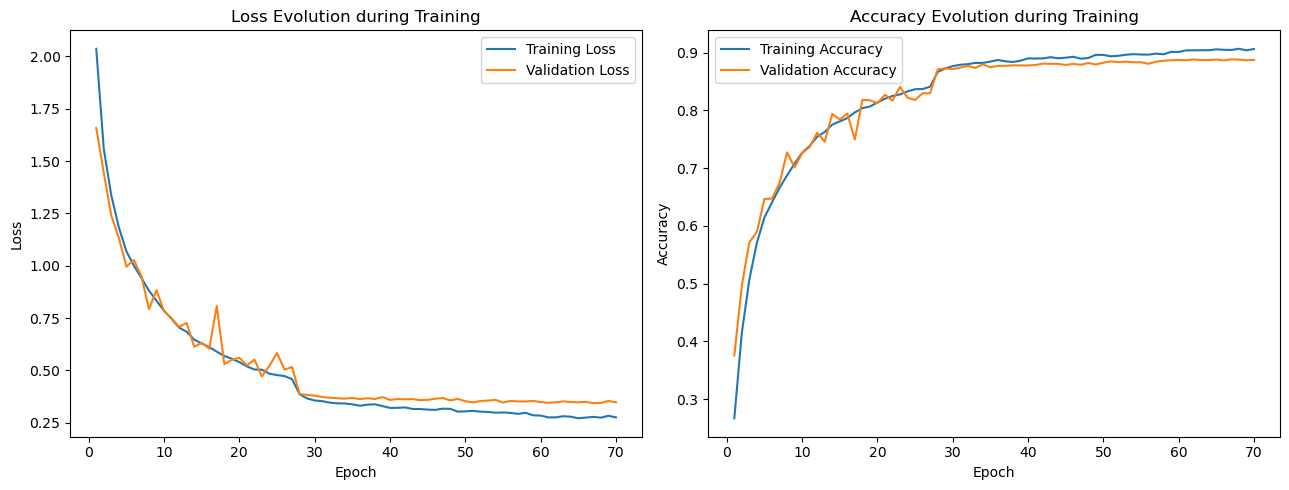

In [11]:
# Configuraciones
use_gpu = torch.cuda.is_available()

# Directorio para guardar checkpoints (opcional)
checkpoint_dir = "CheckpointsResNet68_SD"
os.makedirs(checkpoint_dir, exist_ok=True)
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.04
    n_evaluations_per_epoch = 10
    data_augmentation = True
    weight_decay = 1e-4
    early_stop_thresh = 15
    patience = 3
    survival_prob = 0.5  # Probabilidad de supervivencia para la profundidad estocástica

    # Inicializar el modelo con profundidad estocástica
    model = resnet68_SD(survival_prob=0.5)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_ResNet_110,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

In [17]:
import os
import torch
from torch.utils.data import DataLoader

# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "CheckpointsResNet68_SD"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

# Crear una instancia del modelo ResNet
model = resnet68_SD(survival_prob=0.5)  # Asegúrate de usar la misma configuración que en el entrenamiento

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Crear el DataLoader para el conjunto de prueba
test_loader = DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1, 5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1, 5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")

Mejor modelo encontrado: best_checkpoint_epoch_67.pth


C:\Users\ricar\AppData\Local\Temp\ipykernel_2884\344513432.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Precisión TOP1 en el conjunto de prueba: 88.14%
Precisión TOP5 en el conjunto de prueba: 99.61%


In [12]:
__all__ = ['ResNet', 'resnet68_SD']

def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet68_SD
Total number of params 1047450
Total layers 68

